# Import list
project uses, numpy, scikit-learn, matplotlib, and pandas. The rcParams function sets the graph size

In [860]:
from operator import index

import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from IPython.display import Markdown as md
from tensorflow.python.ops.metrics_impl import true_positives

plt.rcParams['figure.figsize'] = [15, 7]

Read the csv file and drops any non-available values. We then select a dimension of two for X and use the species as the y.

In [861]:
df = pd.read_csv("./outlierDatasets/synthetic.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,outlier
0,0.435518,0.038492,0.551343,0.140049,0.899545,0.588684,0.299706,0.245713,0.367375,0.452970,no
1,0.633197,0.034490,0.319406,0.879141,0.163079,0.184356,0.160583,0.104973,0.294980,0.429709,no
2,0.421558,0.299824,0.602220,0.521654,0.954621,0.547448,0.882898,0.586641,0.840204,0.212529,no
3,0.817491,0.647528,0.046214,0.487270,0.053872,0.817499,0.390589,0.394750,0.736854,0.442689,yes
4,0.291513,0.474018,0.065267,0.410573,0.903696,0.466520,0.196878,0.165370,0.297764,0.467911,no


In [862]:
X = df.iloc[:, 4:6].values
copy_X = df.iloc[:, 2:4]
y = df.iloc[:, -1:].values

In [863]:
le = LabelEncoder()
y = le.fit_transform(y)

C:\Users\khodg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


```main()``` chooses a nearest neighbor size and then fits X and y. After both the index of the neighbors and distances are returned. We will mainly be using the Euclidean distances.

In [864]:
def main(X,y,n):
    nn = NearestNeighbors(n_neighbors=n)
    nn.fit(X, y)
    dist, knn = nn.kneighbors(X)  # returns N index neighbors including self
    return knn, dist

knn, distReturn = main(X,y,15)

We need the total distance for each element in the list. This is done by adding all the values found in the dist array returned from the ```main()```

In [865]:
def generateArr(newDist, median='median'):
    arr = []
    for x in newDist:  # finds the distance away from that point (index 0)
        if median == 'median':
            arr += [np.median(x)]
        elif median == 'sum': # min + median + max
            print(x)
            arr += [x[1]+np.max(x)+np.median(x)]
        elif median == 'max':
            arr += [np.max(x)]
        elif median == 'minMax':
            arr += [np.max(x)+x[1]]
        elif median == 'min':
            arr += [x[1]]
            

    return arr

distReturn = np.array(distReturn)
arr = generateArr(distReturn, median="minMax")

### Equation (6)
Total distance for each index is now stored in a array so we use equation 6 from the paper to determine if the value is outside the boxplot. If so, the value is added to the outliers array

In [866]:
# equation upper = q3 + 1.5 * (q3-q2)
# equation lower = q1 - 1.5 * (q2-q1)
def boxplot(distO,X):
        outliers = []
        indexOutliers = []
        percent = np.quantile(distO, [.25, .50, .75])

        upperL = percent[2] + 1.5 * (percent[1] - percent[0])
        lowerL = percent[0] - 1.5 * (percent[2] - percent[1])

        for x in range(distO.shape[0]):
            if distO[x] > upperL:
                outliers += [X[x]]
                indexOutliers += [x]
            elif distO[x] < lowerL:
                outliers += [X[x]]
                indexOutliers += [x]
        
        return outliers, indexOutliers

arr = np.array(arr)
outliers, indexOutliers = boxplot(arr,X)

```printer()```
transforms the outliers into a numpy array and then plots them against the two X dimensions. y is used to show each color of species. Green is the outlier color

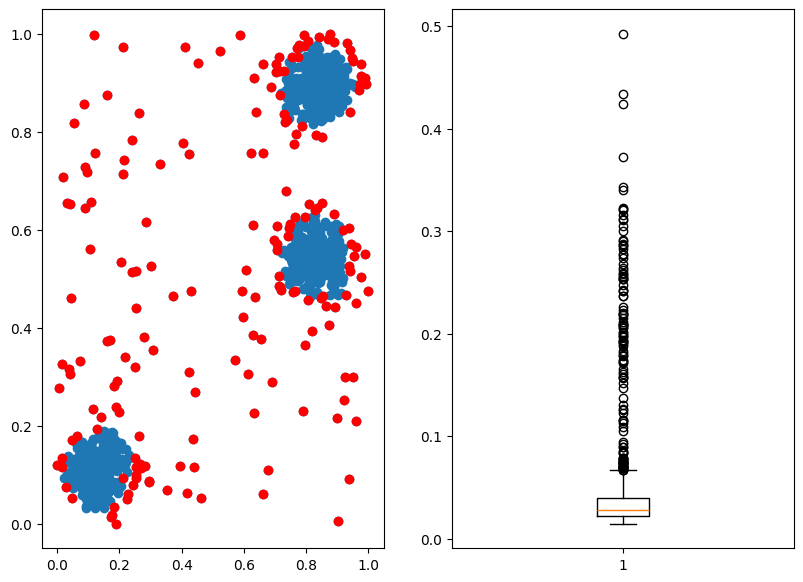

In [867]:
def printer(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()

printer(arr,X,y,outliers)

# Percent Correct

In [868]:
TruePositive = 0
FalsePositive = 0
indexOutliers = np.array(indexOutliers)
print(indexOutliers.size)
trueIndex = []
falseIndex = []
for x in indexOutliers:
    if y[x] == 1:
        TruePositive += 1
        trueIndex.append(x)
    if y[x] == 0:
        FalsePositive += 1
        falseIndex.append(x)
        
trueIndex = np.array(X[trueIndex])
falseIndex = np.array(X[falseIndex])
print(TruePositive, FalsePositive,(TruePositive / indexOutliers.size), (FalsePositive / indexOutliers.size))

189
94 95 0.4973544973544973 0.5026455026455027


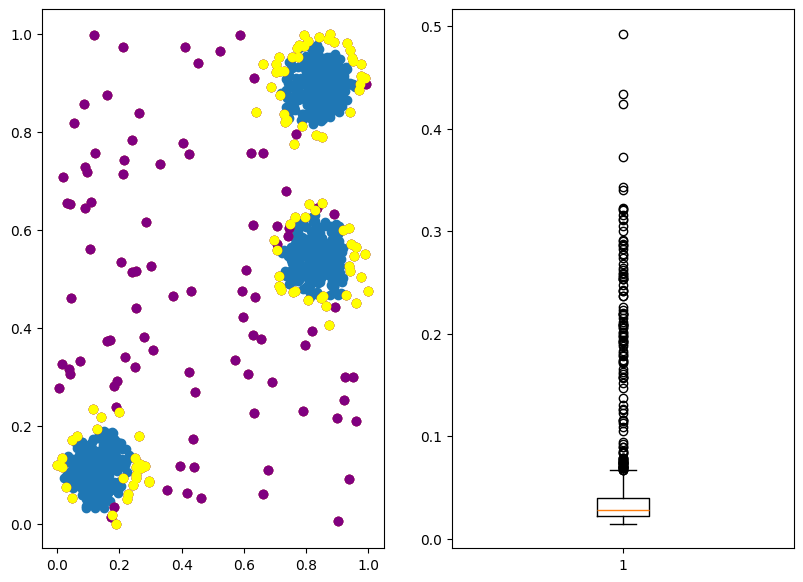

In [869]:
def printerPerc(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.scatter(trueIndex[:, 0], trueIndex[:, 1], c="purple")
    plt.scatter(falseIndex[:, 0], falseIndex[:, 1], c="yellow")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()

printerPerc(arr,X,y,outliers)

### Equation (7a)
Equation 7a follows a similar path as equation 6 other than the difference in upper and lower bounds. We use the variances of distances bigger than Q3 and less than Q1

In [870]:
def boxplot7a(distO,X):
        outliers = []
        outliersIndex = []
        distO = np.array(distO)
        percent = np.quantile(distO, [.25, .50, .75])

        zU = np.sqrt(np.var(distO[distO >= percent[1]]))
        zL = np.sqrt(np.var(distO[distO < percent[1]]))
        print(zL,percent[0])
        
        upperL = percent[2] + 1.5 * zU
        lowerL = percent[0] - 1.5 * zL
        print(lowerL)

        for x in range(distO.shape[0]):
            if distO[x] > upperL:
                outliers += [X[x]]
                outliersIndex += [x]
            elif distO[x] < lowerL:
                outliers += [X[x]]
                outliersIndex += [x]
        
        return outliers, outliersIndex


outliers, indexOutliers = boxplot7a(arr,X)

0.0033230690656978123 0.021843911044498645
0.016859307445951925


After running equation 7a, we map it to a graph and show the outliers as green

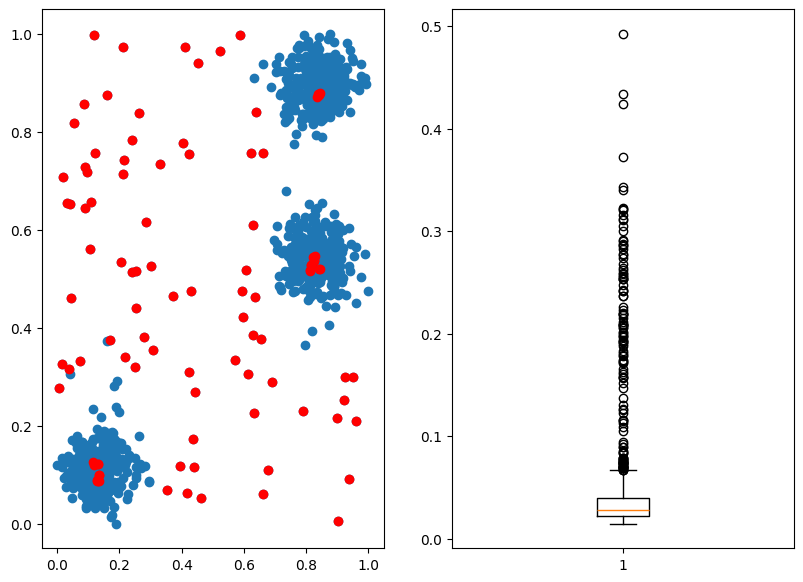

100


In [871]:
def printer7a(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()
    
printer7a(arr,X,y,outliers)
print(len(outliers))

In [872]:
TruePositive = 0
FalsePositive = 0
indexOutliers = np.array(indexOutliers)
trueIndex = []
falseIndex = []
for x in indexOutliers:
    if y[x] == 1:
        TruePositive += 1
        trueIndex.append(x)
    if y[x] == 0:
        FalsePositive += 1
        falseIndex.append(x)

trueIndex = np.array(X[trueIndex])
falseIndex = np.array(X[falseIndex])
print(TruePositive, (TruePositive / indexOutliers.size), FalsePositive, (FalsePositive / indexOutliers.size))

74 0.74 26 0.26


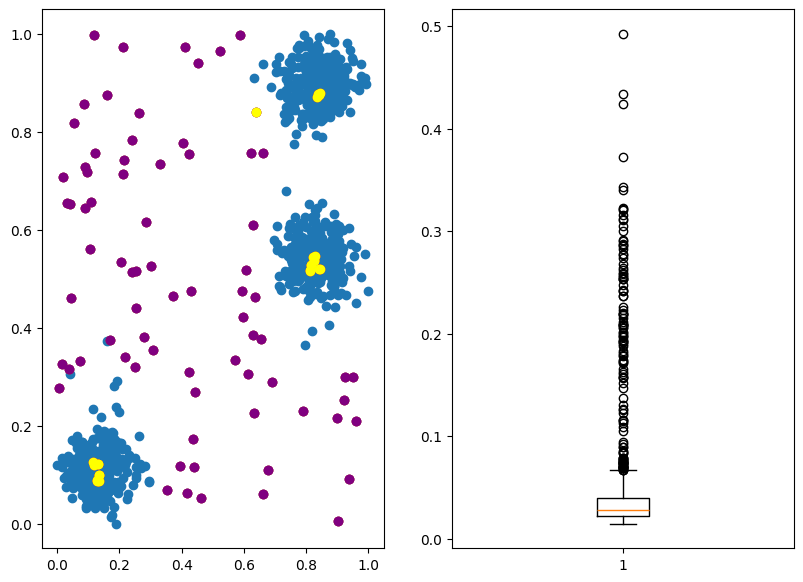

In [873]:
def printerPerc(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.scatter(trueIndex[:, 0], trueIndex[:, 1], c="purple")
    plt.scatter(falseIndex[:, 0], falseIndex[:, 1], c="yellow")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()

printerPerc(arr,X,y,outliers)